In [1]:
import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [81]:
def dry_solution(IC, t1, t2, dt=0.1, prc=np.float16):
    """ IC = (w0, bu0, bs0) tuple
        we don't need dt, because t1 and t2 would be index instead of the actual time"""
    nt_func = t2-t1
    t = np.arange(nt_func)*dt
    
    w = np.zeros(nt_func,dtype=prc)
    bu = np.zeros(nt_func,dtype=prc)
    bs = np.zeros(nt_func,dtype=prc)
    
    w[0], bu[0], bs[0] = IC
    
    bu = bu[0]*np.cos(Nu*t) - Nu*w[0]*np.sin(Nu*t)
    w = w[0]*np.cos(Nu*t) + 1/Nu * bu[0]*np.sin(Nu*t)
    bs = (bs[0] - (Ns**2/Nu**2)*bu[0]) + (Ns**2/Nu**2)*bu[0]*np.cos(Nu*t) - (Ns**2/Nu)*w[0]*np.sin(Nu*t)
    
    M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)
    
    return w, bu, bs, M

def moist_solution(IC, t1, t2, prc=np.float16, dt=0.1):
    """ IC = (w0, bu0, bs0) tuple"""
    nt_func = t2-t1
    t = np.arange(nt_func)*dt
    
    w = np.zeros(nt_func,dtype=prc)
    bu = np.zeros(nt_func,dtype=prc)
    bs = np.zeros(nt_func,dtype=prc)
    
    w[0], bu[0], bs[0] = IC
    
    bs = bs[0]*np.cos(Ns*t) - Ns*w[0]*np.sin(Ns*t)
    w = w[0]*np.cos(Ns*t) + 1/Ns * bs[0]*np.sin(Ns*t)
    bu = (bu[0] - (Nu**2/Ns**2)*bs[0]) + (Nu**2/Ns**2)*bs[0]*np.cos(Ns*t) - (Nu**2/Ns)*w[0]*np.sin(Ns*t)
    
    M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)
    
    return w, bu, bs, M

def nlm_lf(w0, bu0, bs0, nt=50000):
    w = np.zeros(nt)
    bu = np.zeros(nt)
    bs = np.zeros(nt)
    
    w[0] = w0
    bs[0] = bs0
    bu[0] = bu0
    
    dt = 0.1
    
    # leap frog
    for t in range(1):
        if bs[t] > bu[t]:
            w[t+1] = w[t] + bs[t]*dt
        else:
            w[t+1] = w[t] + bu[t]*dt

        bu[t+1] = bu[t] - (Nu**2)*w[t]*dt
        bs[t+1] = bs[t] - (Ns**2)*w[t]*dt



    for t in range(1,nt-1):
        if bs[t] > bu[t]:
            w[t+1] = w[t-1] + bs[t]*2.*dt
        else:
            w[t+1] = w[t-1] + bu[t]*2.*dt

        bu[t+1] = bu[t-1] - (Nu**2)*w[t]*2.*dt
        bs[t+1] = bs[t-1] - (Ns**2)*w[t]*2.*dt
   
    return w, bu, bs

In [82]:
Nu = 0.12   
Ns = 0.012

nt_global = 50000

w0 = 0.1
bu0 = 0.5
bs0 = 0.1

w_num, bu_num, bs_num = nlm_lf(w0, bu0, bs0, nt=nt_global)

Text(0.5, 1.0, 'numerical solution')

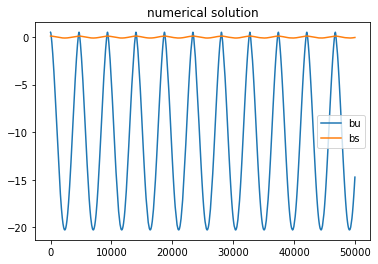

In [83]:
plt.plot(bu, label='bu')
plt.plot(bs, label='bs')
plt.legend()
plt.title("numerical solution")

In [84]:
a = np.where(bu_num>bs_num)[0]
b = np.where((a[1:]- a[:-1])>1)[0] #counting the ones on the right 1st, 3rd, 5th, .. intersection
idx_its = sorted([0] + a[b].tolist() + a[b+1].tolist())
print(idx_its)

[0, 112, 4561, 4790, 9239, 9467, 13916, 14145, 18594, 18822, 23271, 23500, 27949, 28178, 32627, 32855, 37304, 37533, 41982, 42210, 46659]


Text(0.5, 1.0, 'numerical solution')

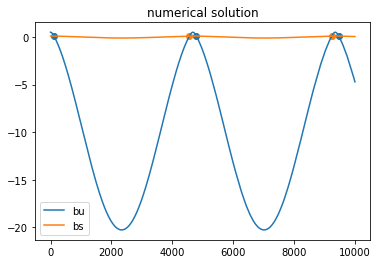

In [85]:
plt.plot(bu[:10000], label='bu')
plt.plot(bs[:10000], label='bs')
plt.scatter(a[b][:3],bu[a[b][:3]])
plt.scatter(a[b[:2]+1],bu[a[b[:2]+1]])
plt.legend()
plt.title("numerical solution")

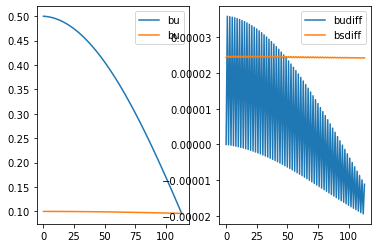

In [86]:
# start with dry phase
w_dry, bu_dry, bs_dry, M = dry_solution(IC=(w0, bu0, bs0), t1=idx_its[0], t2=idx_its[1]+2)

fig,ax = plt.subplots(ncols=2)
ax[0].plot(bu_dry, label='bu')
ax[0].plot(bs_dry, label='bu')
ax[0].legend()

ax[1].plot(bu_num[idx_its[0]:idx_its[1]+2]-bu_dry, label='budiff')
ax[1].plot(bs_num[idx_its[0]:idx_its[1]+2]-bs_dry, label='bsdiff')
ax[1].legend()

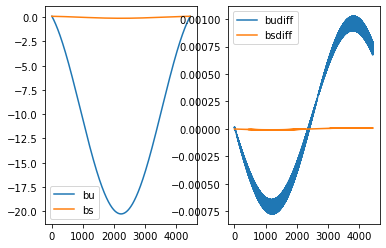

In [87]:
# start with dry phase
w_sat, bu_sat, bs_sat, M = moist_solution(IC=(w_num[idx_its[1]], bu_num[idx_its[1]], bs_num[idx_its[1]]),
                                        t1=idx_its[1], t2=idx_its[2]+1)
fig,ax = plt.subplots(ncols=2)
ax[0].plot(bu_sat, label='bu')
ax[0].plot(bs_sat, label='bs')
ax[0].legend()

ax[1].plot(bu_num[idx_its[1]:idx_its[2]+1]-bu_sat, label='budiff')
ax[1].plot(bs_num[idx_its[1]:idx_its[2]+1]-bs_sat, label='bsdiff')
ax[1].legend()

### dry phase

In [110]:
nt = 5000
w = np.zeros(nt,dtype=np.float16)
bu = np.zeros(nt,dtype=np.float16)
bs = np.zeros(nt,dtype=np.float16)
dt = 0.1
Nu = 1.2e-1      # Holton pp 58
Ns = Nu/10.

w[0] = 0.1
bu[0] = 0.1
bs[0] = 0.15

In [111]:
t = dt*np.arange(nt)
bu = bu[0]*np.cos(Nu*t) - Nu*w[0]*np.sin(Nu*t)
w = w[0]*np.cos(Nu*t) + 1/Nu * bu[0]*np.sin(Nu*t)
bs = (bs[0] - (Ns**2/Nu**2)*bu[0]) + (Ns**2/Nu**2)*bu[0]*np.cos(Nu*t) - (Ns**2/Nu)*w[0]*np.sin(Nu*t)

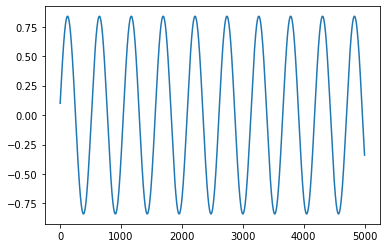

In [112]:
plt.plot(w)

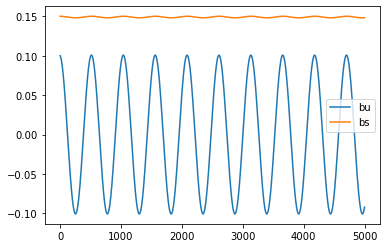

In [113]:
plt.plot(bu, label='bu')
plt.plot(bs, label='bs')
plt.legend()

-1382.0

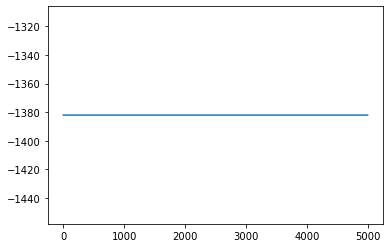

In [85]:
#M = 1/Nu**2 * bu + 1/Ns**2 * bs
M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)
plt.plot(M)
M[0]


### moist phase

In [106]:
w[0] = 0.1
bu[0] = 0.5
bs[0] = 0

nt=50000
t = dt*np.arange(nt)
bs = bs[0]*np.cos(Ns*t) - Ns*w[0]*np.sin(Ns*t)
w = w[0]*np.cos(Ns*t) + 1/Ns * bs[0]*np.sin(Ns*t)
bu = (bu[0] - (Nu**2/Ns**2)*bs[0]) + (Nu**2/Ns**2)*bs[0]*np.cos(Ns*t) - (Nu**2/Ns)*w[0]*np.sin(Ns*t)

M = (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)

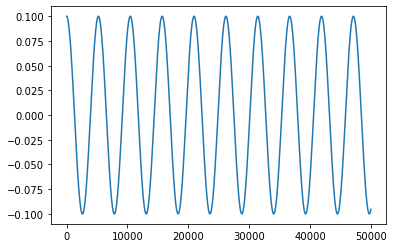

In [107]:
plt.plot(w)

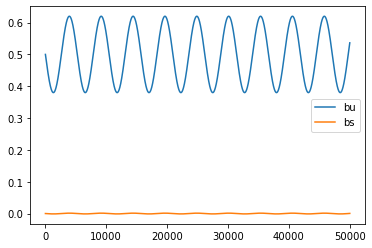

In [108]:
plt.plot(bu, label='bu')
plt.plot(bs, label='bs')
plt.legend()

In [109]:
M =  (1/Nu**2 * bu - 1/Ns**2 * bs).astype(np.float16)
M[0]

34.72